# DIVA in Jupyter Notebook

* Interpolate in situ observation of the Black Sea on a regular grid
* The first step is to load modules

In [1]:
using divand
using NetCDF
using OceanPlot
using PyPlot

* Get data from EUDAT's B2DROP

In [2]:
fname = "B2DROP/Data/divand-example-data/BlackSea/Salinity.bigfile"
bathname = "B2DROP/Data/divand-example-data/Global/Bathymetry/gebco_30sec_16.nc"

obsvalue,obslon,obslat,obsdepth,obstime,obsid = loadbigfile(fname);

* setup the domain
  * define resolution
  * geographical bounding box
  * the depth range 
  * time time range


In [3]:
dx = dy = 0.1
lonr = 27:dx:42
latr = 40:dy:47
depthr = [0.]
timer = 1:1:12

1:1:12

* the relative error variance on the observations

In [4]:
epsilon2 = 0.1

0.1

* correlation length

In [5]:
# sz is the size of the domain
sz = (length(lonr),length(latr),length(depthr),length(timer))

# horizontal correlation length in meters
lenx = 200_000
leny = 200_000

# vertical correlation length in meters
lenz = Array{Float64}(sz)
for n = 1:sz[4]
    for k = 1:sz[3]
        for j = 1:sz[2]
            for i = 1:sz[1]
                lenz[i,j,k,n] = 10 + depthr[k]/5
            end
        end
    end
end

# correlation time-scale in month
lent = 1.

1.0

* run DIVA

* Determine the field $\varphi$ close to the observations $d_j$ for $j=1,N_d$
$$
J[\varphi]=\sum_{j=1}^{N_d}\mu_{j}[d_{j}-\varphi(x_{j},y_{j})]^{2}+ \|
\varphi-\varphi_{b}\| ^{2}
$$

where the regularization constrain is given by
$$
\|\varphi\|^2=\int_{D}( \alpha_{2} \nabla\nabla\varphi :
\nabla\nabla\varphi +\alpha_{1} \nabla\varphi \cdot \nabla\varphi +
\alpha_{0} \varphi^{2}) dD
$$

The parameters $\mu$, $\alpha_0$, $\alpha_1$, $\alpha_2$ are coefficients related to the accuracy of the observations and to the correlation length. $\varphi_{b}$ is a background estimate.

In [6]:
@time fi = diva(("longitude","latitude","depth","time"),
          (lonr,latr,depthr,timer),
          (obslon,obslat,obsdepth,obstime),
          obsvalue, epsilon2,
          (lenx,leny,lenz,lent),
          divand.aggregation_monthly;
          bathname = bathname
);

 32.735618 seconds (29.08 M allocations: 2.214 GB, 3.12% gc time)


* view the result

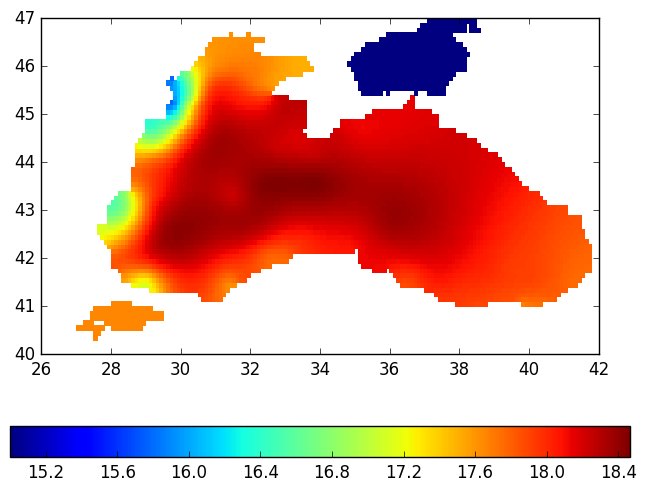

In [7]:

OceanPlot.pcol(lonr,latr,fi[:,:,1,1]',vmin=15.); colorbar(orientation = "horizontal")
set_aspect_ratio()

* Interactive visualization

In [8]:
using Interact

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(6, nactions=1),"month",6,"6",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(2=>"2",11=>"11",7=>"7",9=>"9",10=>"10",8=>"8",6=>"6",4=>"4",3=>"3",5=>"5"…)),Any[],Any[],true,"horizontal")

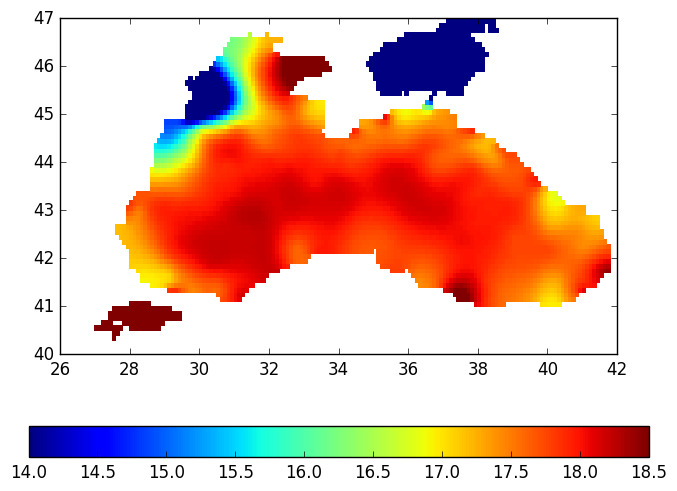

In [9]:
f = figure()
@manipulate for month = 1:12; 
    withfig(f) do
        clf()
        OceanPlot.pcol(lonr,latr,fi[:,:,1,month]',vmin=14.,vmax=18.5); colorbar(orientation = "horizontal")
        set_aspect_ratio()
    end
end